In [107]:
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as mplPolygon
from cartopy.mpl.geoaxes import GeoAxes
from metpy.plots import USCOUNTIES
import datetime
import numpy as np
import json
import metpy
from siphon.catalog import TDSCatalog
from metpy.io import parse_metar_file
from datetime import datetime, timedelta
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
from metpy.io import parse_metar_file
import metpy.plots as mpplots
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import pandas as pd


In [108]:
url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=ACB&station=ADG&station=AMN&station=ANJ&station=APN&station=ARB&station=AZO&station=BAX&station=BEH&station=BIV&station=BTL&station=CAD&station=CFS&station=CIU&station=CMX&station=CVX&station=D95&station=DET&station=DRM&station=DTW&station=DUH&station=ERY&station=ESC&station=FFX&station=FKS&station=FNT&station=FPK&station=GLR&station=GOV&station=GRR&station=HAI&station=HTL&station=HYX&station=IKW&station=IMT&station=IRS&station=ISQ&station=IWD&station=JXN&station=JYM&station=LAN&station=LDM&station=LWA&station=MBL&station=MBS&station=MCD&station=MGN&station=MKG&station=MNM&station=MOP&station=MTC&station=OEB&station=ONZ&station=OSC&station=OZW&station=P53&station=P58&station=P59&station=P75&station=PHN&station=PLN&station=PTK&station=PZQ&station=RMY&station=RNP&station=RQB&station=SAW&station=SJX&station=SLH&station=TEW&station=TTF&station=TVC&station=VLL&station=Y31&station=Y70&station=YIP&data=all&year1=2022&month1=11&day1=18&year2=2022&month2=11&day2=19&tz=Etc%2FUTC&format=onlycomma&latlon=yes&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'
df = pd.read_csv(url)
index_num = len(df.axes[0])
keep = index_num - 74
df_parsed = df.tail(302)
df_parsed = df_parsed.drop_duplicates(subset=['station'])
df_parsed['tmpf'] = df_parsed['tmpf'].astype(str)
df_parsed['relh'] = df_parsed['relh'].astype(str)
df_parsed['drct'] = df_parsed['drct'].astype(str)
df_parsed['WSPD'] = df_parsed['sknt'].astype(str)
df_parsed['dwpf'] = df_parsed['dwpf'].astype(str)

df_parsed['tmpf'] = df_parsed['tmpf'].str.replace('M', '')
df_parsed['relh'] = df_parsed['relh'].str.replace('M', '')
df_parsed['WD'] = df_parsed['drct'].str.replace('M', '')
df_parsed['WSPD'] = df_parsed['sknt'].str.replace('M', '')
df_parsed['dwpf'] = df_parsed['dwpf'].str.replace('M', '')

df_parsed['tmpf'] = pd.to_numeric(df_parsed['tmpf'])
df_parsed['relh'] = pd.to_numeric(df_parsed['relh'])
df_parsed['WD'] = pd.to_numeric(df_parsed['WD'])
df_parsed['WSPD'] = pd.to_numeric(df_parsed['WSPD'])
df_parsed['dwpf'] = pd.to_numeric(df_parsed['dwpf'])

mi_u, mi_v = mpcalc.wind_components(df_parsed['WSPD'].values * units.mph, df_parsed['WD'].values * units.degrees)
mi_dewpoint = mpcalc.dewpoint_from_relative_humidity(df_parsed['tmpf'].values * units.degC, df_parsed['relh'].values * units.percent)

temperature = df_parsed['tmpf'].values * units.degF
dewpoint = df_parsed['dwpf'].values * units.degF

In [109]:
url = 'https://mesonet.agron.iastate.edu/geojson/vtec_event.py?wfo=GRR&year=2022&phenomena=WS&etn=4&significance=W'
response = requests.get(url)
data = response.json()

events = data['features']
warning_data = []

for event in events:
    properties = event['properties']
    geometry = event['geometry']
    id = event['id']
    phenomena = properties['phenomena']
    eventid = properties['eventid']
    warning_data.append([id, phenomena, eventid, geometry])
df = pd.DataFrame(warning_data, columns=['id', 'phenomena', 'eventid', 'geometry'])

        id phenomena  eventid  \
0   MIZ056        WS        4   
1   MIZ064        WS        4   
2   MIZ071        WS        4   
3   MIZ057        WS        4   
4   MIZ058        WS        4   
5   MIZ065        WS        4   
6   MIZ066        WS        4   
7   MIZ072        WS        4   
8   MIZ073        WS        4   
9   MIZ045        WS        4   
10  MIZ037        WS        4   
11  MIZ051        WS        4   
12  MIZ043        WS        4   
13  MIZ050        WS        4   
14  MIZ038        WS        4   
15  MIZ039        WS        4   
16  MIZ044        WS        4   

                                             geometry  
0   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
1   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
2   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
3   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
4   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
5   {'type': 'MultiPolygon', 'coordinates': [[[[-8...  
6   {'type': 

Text(0.5, 1.0, 'NWS GRR WSW and ASOS/AWOS OBS for 2300Z 11/18/2022')

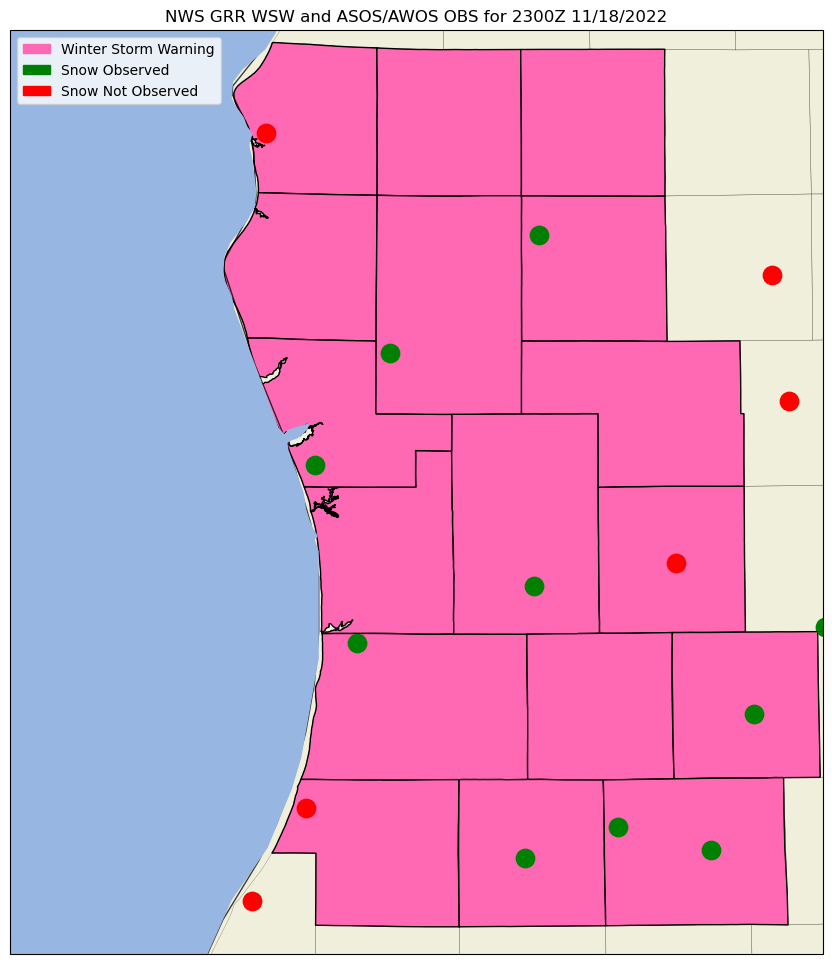

In [110]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-85.6, central_latitude=44.3, standard_parallels=(30, 60)))
ax.set_extent([-87.2, -84.6, 42, 44.2])

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), alpha=.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)

colors = {'WS': '#FF69B4'}

patches = []
legend_patches = []
legend_labels = []

for index, row in df.iterrows():
    geometry = row['geometry']
    
    if geometry:
        geom_type = geometry['type']
        coordinates = geometry['coordinates']
        
        if geom_type == 'MultiPolygon':
            for multi_coords in coordinates:
                for coords in multi_coords:
                    if isinstance(coords[0][0], float):
                        polygon = mplPolygon(coords, closed=True)
                        patches.append(polygon)
                        phenomena_color = colors.get(row['phenomena'], 'gray')
                        #ax.text(coords[0][0], coords[0][1], str(row['eventid']), fontsize=8, transform=ccrs.PlateCarree())

collection = PatchCollection(patches, facecolor=phenomena_color, edgecolor='black', lw=1, transform=ccrs.PlateCarree())
ax.add_collection(collection)

#ax.scatter(df_obs['longitude'], df_obs['latitude'], c='blue', transform=ccrs.PlateCarree())

df_parsed['wxcodes'] = df_parsed['wxcodes'].astype(str)

ax.scatter(df_parsed[df_parsed['wxcodes'] == 'M']['lon'], df_parsed[df_parsed['wxcodes'] == 'M']['lat'], c='red', transform=ccrs.PlateCarree(), label='Snow Not Observed', s=175)
ax.scatter(df_parsed[df_parsed['wxcodes'] != 'M']['lon'], df_parsed[df_parsed['wxcodes'] != 'M']['lat'], c='green', transform=ccrs.PlateCarree(), label='Snow Observed', s=175)

ws = mpatches.Patch(color='#FF69B4', label = 'Winter Storm Warning')
yes = mpatches.Patch(color='green', label = 'Snow Observed')
no = mpatches.Patch(color='red', label = 'Snow Not Observed')
plt.legend(handles=[ws, yes, no], loc='upper left')

plt.title('NWS GRR WSW and ASOS/AWOS OBS for 2300Z 11/18/2022')